In [1]:
import os, sys
import subprocess
import json
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from coffea import processor, util, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from boostedhiggs import VBFArrayProcessor

/opt/conda/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [3]:
with open('xsec.json') as f:
    xs = json.load(f)
with open('pmap.json') as f:
    pmap = json.load(f)
with open('lumi.json') as f:
    lumis = json.load(f)
years = ['2017']#['2016APV','2016','2017','2018']

In [4]:
df_dict = {}

for year in years:
    
    df_dict[year] = {}
    infiles = subprocess.getoutput("ls outfiles-array/"+year+"_dask_*.coffea").split()

    for filename in infiles:
        print("Loading "+filename)

        if os.path.isfile(filename):
            out = util.load(filename)
        
            for k in out.keys():
                cols = list(out[k].keys())
                cols.remove('sumw')
                if 'btagWeight' in cols:
                    cols.remove('btagWeight')
                df = pd.DataFrame(columns=cols)
                for c in cols:
                    df[c] = out[k][c].value
                
                if 'JetHT' not in k and 'SingleMuon' not in k:
                    df['weight'] = df['weight'] * xs[k] * 1000 * lumis[year] / out[k]['sumw']

                df_dict[year][k] = df 


Loading outfiles-array/2017_dask_QCD.coffea


In [5]:
dfs = {}

for year in years:
    dfs[year] = {}   
    
    for k in pmap.keys():
        print(k)
    
        processes = [df_dict[year][p] for p in pmap[k] if p in df_dict[year].keys()]
        if len(processes) == 0:
            continue
        
        dfs[year][k] = pd.concat(processes)

QCD
QCDHT
ttbar
singlet
Wjets
Zjets
ZjetsHT
VV
VVNLO
EWKZ
EWKW
ggF
VBFDipoleRecoilOff
VBF
WH
ZH
ttH
data
muondata


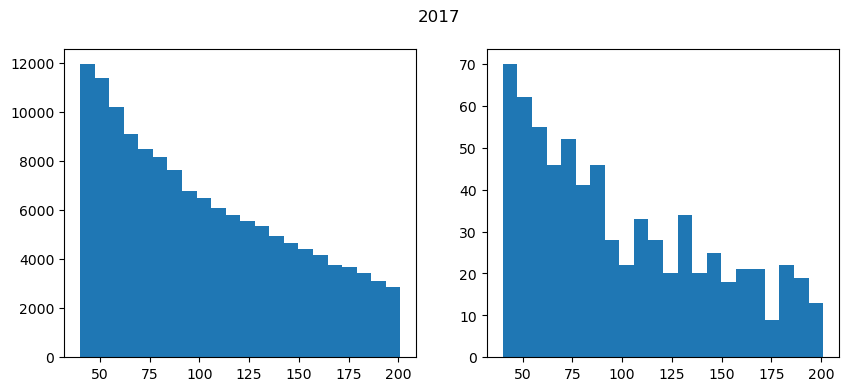

In [6]:
for year in years:
    df = dfs[year]['QCD']
    df_pass = df[df['ddb']>0.64]
    df_fail = df[df['ddb']<0.64]
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    fig.suptitle(year)
    ax[0].hist(df_fail['msd'],bins=np.linspace(40,201,23));
    ax[1].hist(df_pass['msd'],bins=np.linspace(40,201,23));

In [7]:
df = pd.concat([i['QCD'] for k,i in dfs.items()])

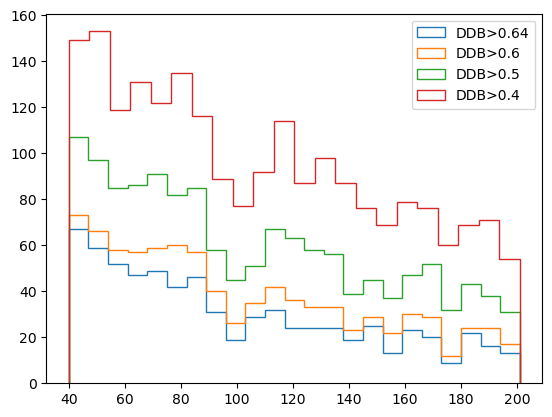

In [8]:
a = plt.hist(df['msd'][df['ddb']>0.64],bins=np.linspace(40,201,24),histtype='step',label='DDB>0.64');
b = plt.hist(df['msd'][df['ddb']>0.6],bins=np.linspace(40,201,24),histtype='step',label='DDB>0.6');
c = plt.hist(df['msd'][df['ddb']>0.5],bins=np.linspace(40,201,24),histtype='step',label='DDB>0.5');
d = plt.hist(df['msd'][df['ddb']>0.4],bins=np.linspace(40,201,23),histtype='step',label='DDB>0.4');
plt.legend()

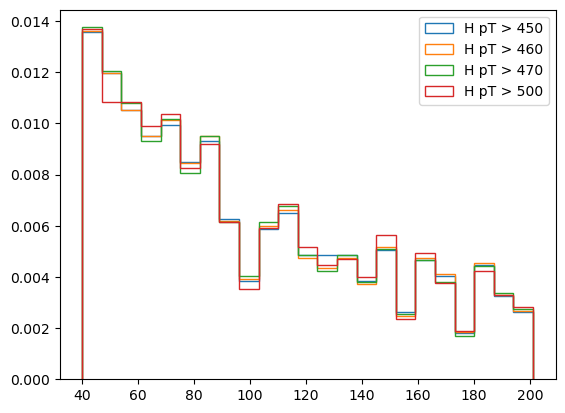

In [10]:
a = plt.hist(df['msd'][(df['pt']>450) & (df['ddb']>0.64)],bins=np.linspace(40,201,24),histtype='step',label='H pT > 450',density=True);
b = plt.hist(df['msd'][(df['pt']>460) & (df['ddb']>0.64)],bins=np.linspace(40,201,24),histtype='step',label='H pT > 460',density=True);
c = plt.hist(df['msd'][(df['pt']>470) & (df['ddb']>0.64)],bins=np.linspace(40,201,24),histtype='step',label='H pT > 470',density=True);
c = plt.hist(df['msd'][(df['pt']>500) & (df['ddb']>0.64)],bins=np.linspace(40,201,24),histtype='step',label='H pT > 500',density=True);
plt.legend()

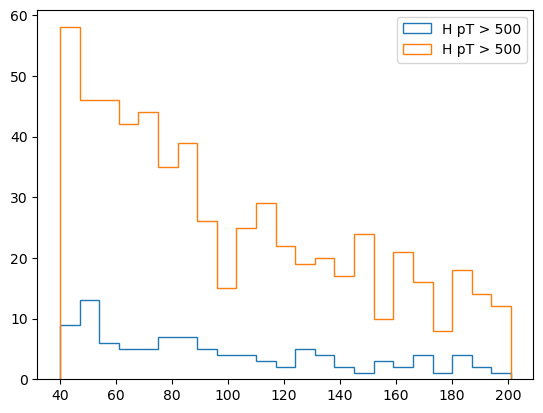

In [12]:
a = plt.hist(df['msd'][(df['pt']<500) & (df['ddb']>0.64)],bins=np.linspace(40,201,24),histtype='step',label='H pT > 500');
b = plt.hist(df['msd'][(df['pt']>500) & (df['ddb']>0.64)],bins=np.linspace(40,201,24),histtype='step',label='H pT > 500');
plt.legend()

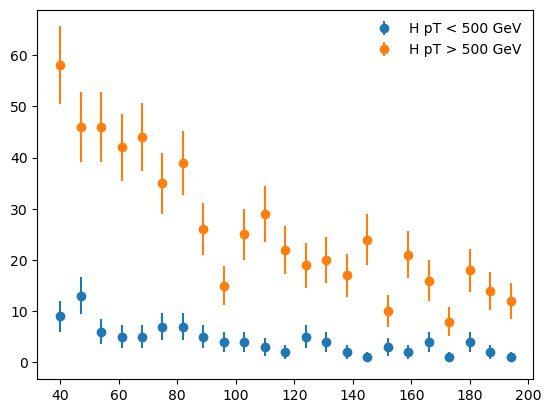

In [13]:
plt.errorbar(x=a[1][:-1],y=a[0],yerr=np.sqrt(a[0]),linestyle="",marker="o",label="H pT < 500 GeV")
plt.errorbar(x=b[1][:-1],y=b[0],yerr=np.sqrt(b[0]),linestyle="",marker="o",label="H pT > 500 GeV")
plt.legend(frameon=False)
plt.show()

In [14]:
from scipy.stats import kstest

kstest(a[0],b[0])

KstestResult(statistic=0.9130434782608695, pvalue=2.5141403000586045e-10)

(array([28., 17., 22., 13.,  7., 11.,  6.,  9.,  6.,  4.]),
 array([ 450.5 ,  522.85,  595.2 ,  667.55,  739.9 ,  812.25,  884.6 ,
         956.95, 1029.3 , 1101.65, 1174.  ]),
 <BarContainer object of 10 artists>)

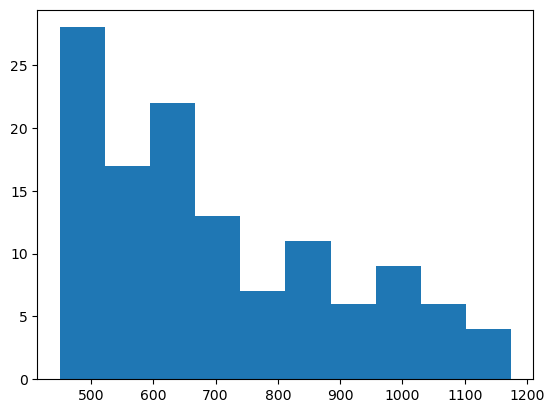

In [15]:
plt.hist(df[(df['ddb']>0.64) & (df['msd']<145) & (df['msd']>110)]['pt'])

In [16]:
df.head()

,genflavor,pt,eta,phi,n2ddt,msd,ddb,deta,dphi,mjj,njets,jet1_pt,jet1_eta,jet1_phi,jet2_pt,jet2_eta,jet2_phi,weight
0,0.0,475.50,0.352295,-0.267029,-0.001116,51.585944,0.000928,3.866699,-0.448242,1272.649658,2.0,275.00,-1.791016,2.603516,127.8125,2.075684,3.051758,98.694735
1,0.0,488.75,-0.288574,2.923340,-0.005217,108.606630,0.000004,3.787476,-0.077118,1354.527588,2.0,290.50,-3.101562,-0.237915,148.1250,0.685913,-0.160797,114.913930
2,0.0,461.75,0.139282,-2.026855,-0.017054,87.944913,0.001822,5.304199,1.343567,3326.006104,3.0,238.25,-2.889160,1.615967,231.2500,2.415039,0.272400,9.539695
3,0.0,471.00,-1.078857,-0.651001,-0.010217,45.858744,0.000293,3.633911,-0.107910,1229.623901,2.0,267.75,3.125488,2.453125,156.6250,-0.508423,2.561035,98.600174
4,0.0,516.00,1.276367,-0.750854,-0.006347,55.065038,0.000007,4.781128,1.702026,1549.540039,2.0,474.50,0.723511,2.471680,42.1250,-4.057617,0.769653,230.632132


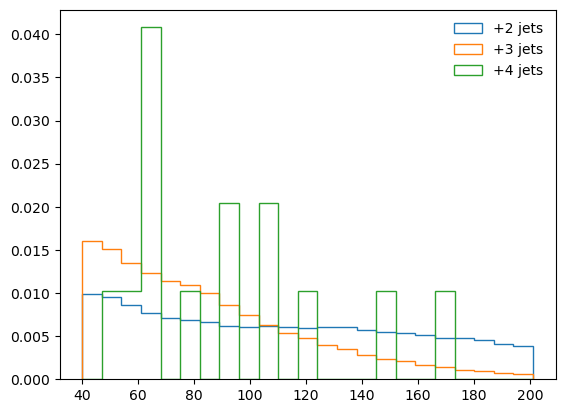

In [31]:
plt.hist(df['msd'][df['njets']==2],bins=np.linspace(40,201,24),density=True,histtype='step',label='+2 jets')
plt.hist(df['msd'][df['njets']==3],bins=np.linspace(40,201,24),density=True,histtype='step',label='+3 jets')
plt.hist(df['msd'][df['njets']==4],bins=np.linspace(40,201,24),density=True,histtype='step',label='+4 jets')
plt.legend(frameon=False)

Text(0.5, 0.98, 'QCD MC, VBF category')

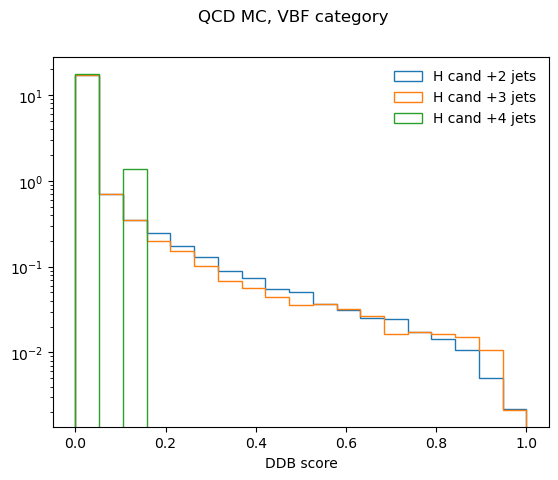

In [38]:
plt.hist(df['ddb'][df['njets']==2],bins=np.linspace(0,1,20),density=True,histtype='step',label='H cand +2 jets')
plt.hist(df['ddb'][df['njets']==3],bins=np.linspace(0,1,20),density=True,histtype='step',label='H cand +3 jets')
plt.hist(df['ddb'][df['njets']==4],bins=np.linspace(0,1,20),density=True,histtype='step',label='H cand +4 jets')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('DDB score')
plt.suptitle('QCD MC, VBF category')

In [41]:
len(df['ddb'][(df['njets']==2) & (df['ddb']>0.64)])/len(df[df['njets']==2])

0.005025658424869587

In [43]:
len(df['ddb'][(df['njets']==3) & (df['ddb']>0.64)])/len(df[df['njets']==3])

0.005199306759098787

Text(0.5, 0.98, 'QCD MC, VBF category, 2 jets')

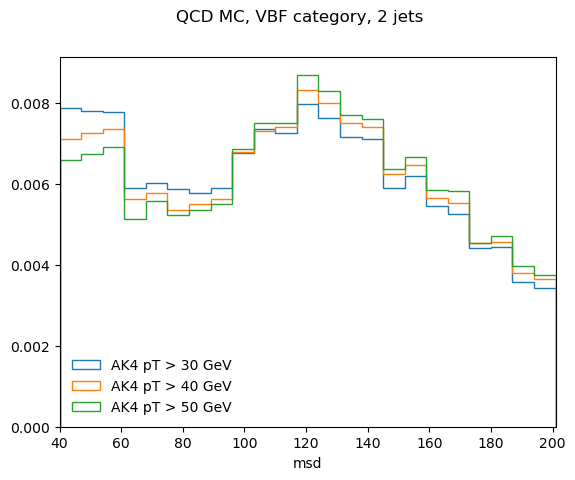

In [72]:
#plt.hist(df['msd'][(df['njets']==2) & (df['jet1_pt'] > 25) & (df['jet2_pt'] > 25)],weights=df['weight'][(df['njets']==2) & (df['jet1_pt'] > 25) & (df['jet2_pt'] > 25)],bins=np.linspace(40,201,24),density=True,histtype='step',label='+2 jets, pT > 25 GeV')
plt.hist(df['msd'][(df['njets']==2) & (df['jet1_pt'] > 30) & (df['jet2_pt'] > 30)],weights=df['weight'][(df['njets']==2) & (df['jet1_pt'] > 30) & (df['jet2_pt'] > 30)],bins=np.linspace(40,201,24),density=True,histtype='step',label='AK4 pT > 30 GeV')
plt.hist(df['msd'][(df['njets']==2) & (df['jet1_pt'] > 40) & (df['jet2_pt'] > 40)],weights=df['weight'][(df['njets']==2) & (df['jet1_pt'] > 40) & (df['jet2_pt'] > 40)],bins=np.linspace(40,201,24),density=True,histtype='step',label='AK4 pT > 40 GeV')
plt.hist(df['msd'][(df['njets']==2) & (df['jet1_pt'] > 50) & (df['jet2_pt'] > 50)],weights=df['weight'][(df['njets']==2) & (df['jet1_pt'] > 50) & (df['jet2_pt'] > 50)],bins=np.linspace(40,201,24),density=True,histtype='step',label='AK4 pT > 50 GeV')

plt.legend(frameon=False,loc='lower left')
plt.xlim(40,201)
plt.xlabel('msd')
plt.suptitle('QCD MC, VBF category, 2 jets')

Text(0.5, 0, 'msd')

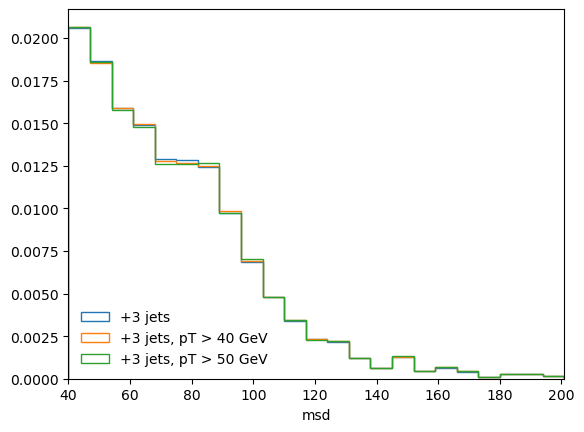

In [66]:
plt.hist(df['msd'][df['njets']==3],weights=df['weight'][df['njets']==3],bins=np.linspace(40,201,24),density=True,histtype='step',label='+3 jets')
plt.hist(df['msd'][(df['njets']==3) & (df['jet1_pt'] > 40) & (df['jet2_pt'] > 40)],weights=df['weight'][(df['njets']==3) & (df['jet1_pt'] > 40) & (df['jet2_pt'] > 40)],bins=np.linspace(40,201,24),density=True,histtype='step',label='+3 jets, pT > 40 GeV')
plt.hist(df['msd'][(df['njets']==3) & (df['jet1_pt'] > 50) & (df['jet2_pt'] > 50)],weights=df['weight'][(df['njets']==3) & (df['jet1_pt'] > 50) & (df['jet2_pt'] > 50)],bins=np.linspace(40,201,24),density=True,histtype='step',label='+3 jets, pT > 50 GeV')

plt.legend(frameon=False,loc='lower left')
plt.xlim(40,201)
plt.xlabel('msd')

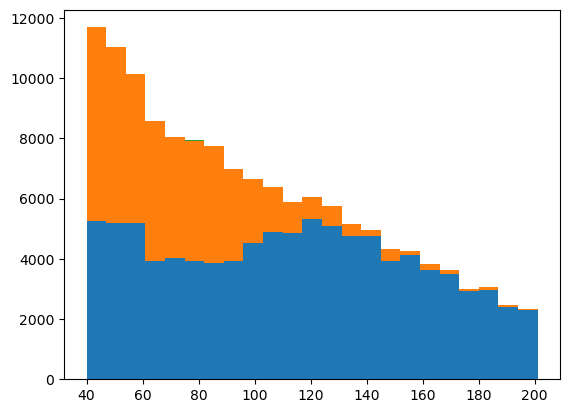

In [56]:
plt.hist([df['msd'][df['njets']==2],df['msd'][df['njets']==3],df['msd'][df['njets']>3]],weights=[df['weight'][df['njets']==2],df['weight'][df['njets']==3],df['weight'][df['njets']>3]],bins=np.linspace(40,201,24),stacked=True);

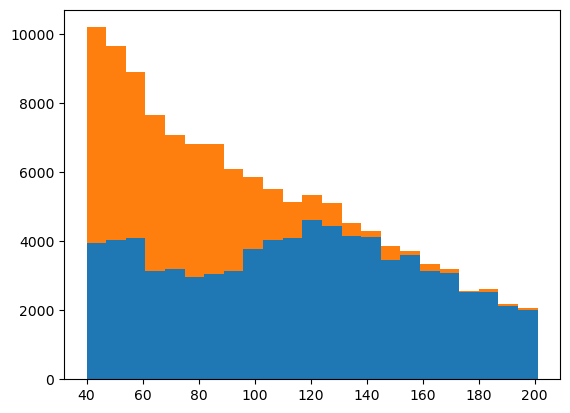

In [70]:
df1 = df[(df['jet1_pt']>40) & (df['jet2_pt']>40)]
plt.hist([df1['msd'][df1['njets']==2],df1['msd'][df1['njets']==3],df1['msd'][df1['njets']>3]],weights=[df1['weight'][df1['njets']==2],df1['weight'][df1['njets']==3],df1['weight'][df1['njets']>3]],bins=np.linspace(40,201,24),stacked=True);

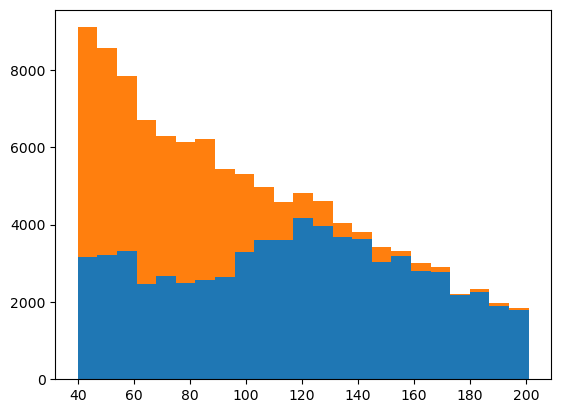

In [71]:
df1 = df[(df['jet1_pt']>50) & (df['jet2_pt']>50)]
plt.hist([df1['msd'][df1['njets']==2],df1['msd'][df1['njets']==3],df1['msd'][df1['njets']>3]],weights=[df1['weight'][df1['njets']==2],df1['weight'][df1['njets']==3],df1['weight'][df1['njets']>3]],bins=np.linspace(40,201,24),stacked=True);

In [55]:
plt.hist([df['msd'][df['njets']==2],df['msd'][df['njets']==3],df['msd'][df['njets']>3]],weights=[df['weight'][df['njets']==2],df['weight'][df['njets']==3],df['weight'][df['njets']>3]],bins=np.linspace(40,201,24),stacked=True);

,genflavor,pt,eta,phi,n2ddt,msd,ddb,deta,dphi,mjj,njets,jet1_pt,jet1_eta,jet1_phi,jet2_pt,jet2_eta,jet2_phi,weight
0,0.0,475.50,0.352295,-0.267029,-0.001116,51.585944,0.000928,3.866699,-0.448242,1272.649658,2.0,275.00,-1.791016,2.603516,127.8125,2.075684,3.051758,98.694735
1,0.0,488.75,-0.288574,2.923340,-0.005217,108.606630,0.000004,3.787476,-0.077118,1354.527588,2.0,290.50,-3.101562,-0.237915,148.1250,0.685913,-0.160797,114.913930
2,0.0,461.75,0.139282,-2.026855,-0.017054,87.944913,0.001822,5.304199,1.343567,3326.006104,3.0,238.25,-2.889160,1.615967,231.2500,2.415039,0.272400,9.539695
3,0.0,471.00,-1.078857,-0.651001,-0.010217,45.858744,0.000293,3.633911,-0.107910,1229.623901,2.0,267.75,3.125488,2.453125,156.6250,-0.508423,2.561035,98.600174
4,0.0,516.00,1.276367,-0.750854,-0.006347,55.065038,0.000007,4.781128,1.702026,1549.540039,2.0,474.50,0.723511,2.471680,42.1250,-4.057617,0.769653,230.632132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,0.0,1003.00,1.050537,-2.528320,-0.014454,46.283245,0.000983,3.536621,1.389374,2449.900879,3.0,689.50,1.688232,1.268555,255.0000,-1.848389,-0.120819,0.000737
7,0.0,531.00,-0.267212,-0.403503,-0.031342,122.424344,0.119019,3.663086,2.951642,2834.707031,3.0,462.75,-1.968750,-0.322266,423.5000,1.694336,3.009277,0.000687
8,0.0,1064.00,0.178223,1.093506,-0.030638,41.662371,0.000226,4.356201,-0.697266,3104.760986,2.0,944.00,-1.552979,-2.113770,133.5000,2.803223,-1.416504,0.000559
9,0.0,942.50,-1.121826,2.178223,-0.068187,66.606900,0.155518,3.865112,-1.406921,2409.767334,3.0,607.50,-0.732788,-1.131836,199.5000,3.132324,0.275085,0.000866
